In [1]:
import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time, os

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib as mpl

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

from IPython import display
import sys

sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf")

import naf
import scipy as sp
import math

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import init

from sklearn.preprocessing import RobustScaler,MinMaxScaler

<h1> Density Estimation via NAF </h1>

In [2]:
# Loading in a generated halo
nfwHalo = np.load('generatedHalos//nfwGeneratedTracers_Apr_20_2021_2046.npz')
haloInfo = nfwHalo['arr_1']
genPhaseSpace = np.transpose(nfwHalo['arr_3'])

print("nTracers is: " + str(haloInfo[0]) + ". rScale is: " + str(haloInfo[1]) + " pc. mwHaloDensity is: " + str(haloInfo[2]) + " solar masses per cubic parsec. delta is: " + str(haloInfo[3]) + ". criticalDensity is: " + str(haloInfo[4]))

nTracers is: 10000.0. rScale is: 8100.0 pc. mwHaloDensity is: 0.00718 solar masses per cubic parsec. delta is: 200.0. criticalDensity is: 1.26e-07


In [3]:
np.shape(genPhaseSpace)

(10000, 6)

In [4]:
class EntropyDataset(Dataset):
    def __init__(self,data):
        self.data=data
        
    def __len__(self):
        self.len=len(self.data)
        return self.len

    def __getitem__(self, idx):
        datum = self.data[idx]
        return datum

In [7]:
train_set = EntropyDataset(genPhaseSpace)

my_batch_size=128

train_loader = DataLoader(train_set, batch_size=my_batch_size,
                        shuffle=True,pin_memory=True)
# BECAUSE THIS IS UNSUPERVISED DENSITY ESTIMATION WE USE THE SAME TEST=TRAIN SET
test_loader = DataLoader(train_set, batch_size=1000,
                        shuffle=False,pin_memory=True)

denaf = naf.DensityEstimator(flowtype=1,dim=6,lr=0.0001)
epochs = 60

In [8]:
denaf.fit(train_loader, save_directory = 'results/nfw_example/',total=epochs)

Iteration: [   1/  60] loss: 20646.90560000
Iteration: [   2/  60] loss: 7618.42960000
Iteration: [   3/  60] loss: 4755.61000000
Iteration: [   4/  60] loss: 3087.56620000
Iteration: [   5/  60] loss: 2038.21200000
Iteration: [   6/  60] loss: 1399.55420000
Iteration: [   7/  60] loss: 978.67430000
Iteration: [   8/  60] loss: 707.74945000
Iteration: [   9/  60] loss: 504.82990000
Iteration: [  10/  60] loss: 403.75050000
Iteration: [  11/  60] loss: 327.14445000
Iteration: [  12/  60] loss: 282.50542500
Iteration: [  13/  60] loss: 250.80952500
Iteration: [  14/  60] loss: 210.61187500
Iteration: [  15/  60] loss: 183.06832500
Iteration: [  16/  60] loss: 163.91773750
Iteration: [  17/  60] loss: 152.21632500
Iteration: [  18/  60] loss: 136.94725000
Iteration: [  19/  60] loss: 124.70473750
Iteration: [  20/  60] loss: 115.85066250
Iteration: [  21/  60] loss: 105.91335000
Iteration: [  22/  60] loss: 97.84092500
Iteration: [  23/  60] loss: 91.71231875
Iteration: [  24/  60] loss: 

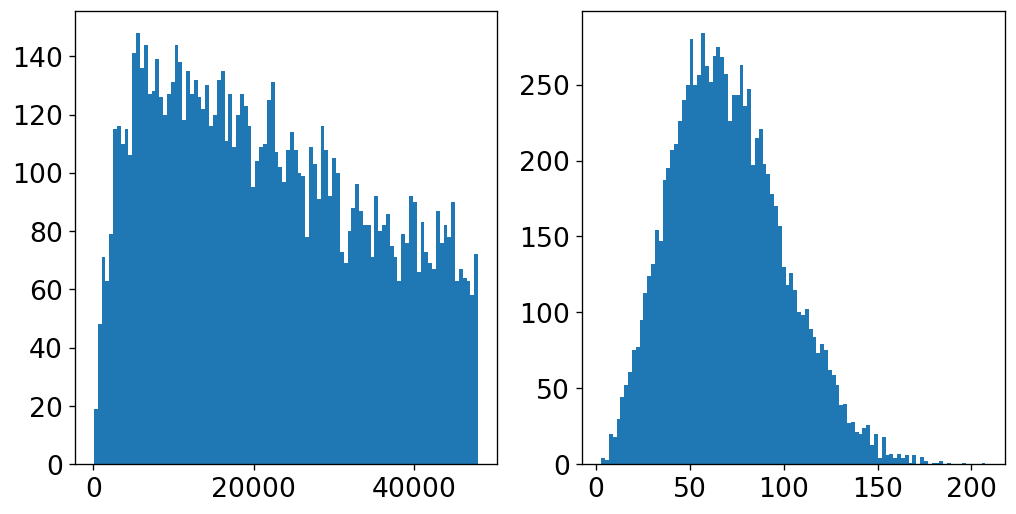

In [9]:
# what are any of these plots? 0_o

fig = plt.figure(figsize=(10, 5), dpi= 120)

ax = fig.add_subplot(121)

_,_,_ = ax.hist(np.sqrt(np.sum(genPhaseSpace[:,0:3]**2,axis=1)),bins=100)
#ax.set_yscale('log')


ax = fig.add_subplot(122)

_,_,_ = ax.hist(np.sqrt(np.sum(genPhaseSpace[:,3:6]**2,axis=1)),bins=100)
#ax.set_yscale('log')

In [10]:
# What's happening in the next few cells?

logprob = np.zeros(len(genPhaseSpace)) # initializing the log probability array
gradient = np.zeros_like(genPhaseSpace) # initializing the gradient array
#acceleration = np.zeros((genPhaseSpace.shape[0],genPhaseSpace.shape[-1],genPhaseSpace.shape[-1])) # initializing the acceleration array

min_epoch = 40

for i in range(min_epoch,epochs):
    denaf.mdl.load_state_dict(torch.load("results/nfw_example/nafmodel_"+str(i)+".dict"))
    logprob_temp = np.empty(0)
    gradient_temp = np.empty(0)
    #acceleration_temp = np.empty(0)
    for batch_idx, data in enumerate(test_loader):
        logprob_temp = np.concatenate((logprob_temp,denaf.density(data.cuda().float()).cpu().detach().numpy()))
        grad,acc = denaf.return_grad(data.cuda().float())
        gradient_temp = np.concatenate((gradient_temp,grad.cpu().detach().numpy().flatten()))
        #acceleration_temp = np.concatenate((acceleration_temp,acc.cpu().detach().numpy().flatten()))
    gradient_temp = gradient_temp.reshape(-1,genPhaseSpace.shape[-1])
    #acceleration_temp = acceleration_temp.reshape(-1,genPhaseSpace.shape[-1],genPhaseSpace.shape[-1])
            
    logprob += logprob_temp
    gradient += gradient_temp
    #acceleration += acceleration_temp
    
logprob = logprob/len(range(min_epoch,epochs))
gradient = gradient/len(range(min_epoch,epochs))
#acceleration = acceleration/len(range(min_epoch,epochs))

In [20]:
for batch_idx, data in enumerate(test_loader):
        print(batch_idx)
        print(np.shape(data))

0
torch.Size([1000, 6])
1
torch.Size([1000, 6])
2
torch.Size([1000, 6])
3
torch.Size([1000, 6])
4
torch.Size([1000, 6])
5
torch.Size([1000, 6])
6
torch.Size([1000, 6])
7
torch.Size([1000, 6])
8
torch.Size([1000, 6])
9
torch.Size([1000, 6])


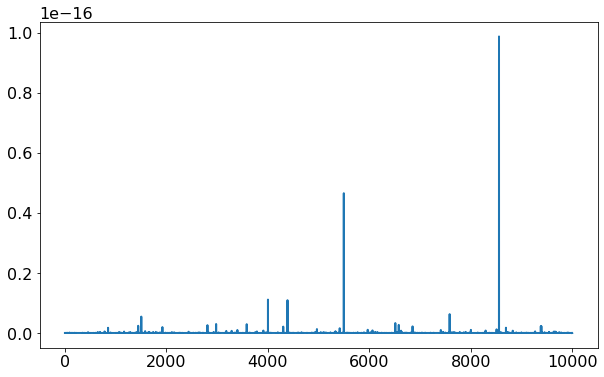

In [15]:
plt.plot(np.exp(logprob))

In [21]:
testpoints = np.vstack([np.linspace(-30,30,20),
                       np.linspace(-30,30,20),
                       np.linspace(-30,30,20),
                       np.linspace(-20,20,20),
                       np.linspace(-20,20,20),
                       np.linspace(-20,20,20)]).T

In [26]:
eval_set = EntropyDataset(testpoints)

eval_loader = DataLoader(eval_set, batch_size=20,
                        shuffle=False,pin_memory=True)

In [27]:
denaf.mdl.load_state_dict(torch.load("results/nfw_example/nafmodel_"+str(epochs-1)+".dict"))
for batch_idx, data in enumerate(eval_loader):
    print(denaf.density(data.cuda().float()).cpu().detach().numpy())

[-38.395157 -38.175056 -37.981873 -37.823616 -37.71027  -37.636253
 -37.56656  -37.50042  -37.274693 -35.86134  -35.711285 -37.07159
 -37.42633  -37.63813  -37.779198 -37.900444 -38.02389  -38.15858
 -38.311996 -38.49026 ]


In [13]:
np.shape(testpoints)

(20, 6)